In [1]:
#imports
from scipy.spatial import distance_matrix
from random import randrange
import copy
import matplotlib.pyplot as plt
import imageio

In [2]:
#loading datasets 
import numpy as np
kroa={}
krob={}
np_kroa=[]
np_krob=[]
with open('kroa100.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        kroa[x[0]]=(x[1],x[2])
        np_kroa.append((x[1],x[2]))
np_kroa=np.array(np_kroa)
with open('krob100.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        krob[x[0]]=(x[1],x[2])
        np_krob.append((x[1],x[2]))

np_kroa=np.array(np_kroa)
np_krob=np.array(np_krob)

#calculating distance matrix - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html
dista=distance_matrix(np_kroa,np_kroa)
distb=distance_matrix(np_krob,np_krob)

In [3]:
#plotting functions
def plotResult(np_dots, cycles):
    plt.plot(np_dots[:,0][cycles[0][0]], np_dots[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[1][0]], np_dots[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[0]], np_dots[:,1][cycles[0]], "->")
    plt.plot(np_dots[:,0][cycles[1]], np_dots[:,1][cycles[1]], "->")
    plt.show()
    
def plotPartResult(np_dots, cycles,i):
    plt.plot(np_dots[:,0][cycles[0][0]], np_dots[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[1][0]], np_dots[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[0]], np_dots[:,1][cycles[0]], "->")
    plt.plot(np_dots[:,0][cycles[1]], np_dots[:,1][cycles[1]], "->")
    plt.plot(np_dots[:,0], np_dots[:,1], ".")
    plt.savefig(f'plots/{i}.png')
    plt.show()    
def calcDistance(currentCycle, dist):
    distance = 0
    for x,y in zip(currentCycle, [*currentCycle[1:], currentCycle[0]]):
        distance += dist[x][y]
    return distance 

In [4]:
# 1st variable - Start cycle - with random assignments
def start_cycle_random(dataset_choice="kroa"):
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)
    candidates=np.arange(0,100,1)
    #print(candidates)
    cycles={}
    cycles[0]=[randrange(100)]
    candidates=np.delete(candidates, cycles[0][0])
    cycles[1]=[(np.argsort(dist[cycles[0][0]])[-2])]
    candidates=np.delete(candidates, cycles[1][0])
    chosenCycle=1
    for i in range(0,98):
        chosenCycle = int((chosenCycle + 1)%2)
        chosenElementIndex = np.random.randint(len(candidates))
        #print(chosenElementIndex,len(candidates),candidates[chosenElementIndex])
        #cycles[chosenCycle]=np.insert(cycles[chosenCycle],candidates[chosenElementIndex])
        cycles[chosenCycle]=np.concatenate((cycles[chosenCycle], [candidates[chosenElementIndex]]), axis=0)
        candidates=np.delete(candidates, chosenElementIndex)
    return cycles


In [5]:
# 1st variable - Start cycle - with nearest neighbour method
def start_cycle_heuristic(dataset_choice="kroa"):
    results=[]
    min_result=np.inf
    max_result=0
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)


    #zmiana dystansu przekątnej na nieskonczonosc
    np.fill_diagonal(dist, np.inf)

    cycles={}
    cycles[0]=[randrange(100)]
    cycles[1]=[(np.argsort(dist[cycles[0][0]])[-2])]

    for b in range(2):
        dist[:,int(cycles[b][0])]=np.inf

    chosenCycle=1
    for i in range(0,98):
        chosenCycle = int((chosenCycle + 1)%2)
        candidates=[]
        for z,index in enumerate(cycles[chosenCycle]):
            candidates.append((np.argmin(dist[index]),np.min(dist[index]),z))
        candidates=np.array(candidates)
        x=np.argmin(candidates[:,1])
        cycles[chosenCycle]=np.insert(cycles[chosenCycle],int(candidates[x,2]),int(candidates[x,0]))
        dist[:,int(candidates[x,0])]=np.inf
    
    print(f"cycle[0]: {calcDistance(cycles[0], dist_stable)}")
    print(f"cycle[1]: {calcDistance(cycles[1], dist_stable)}")
    
    #SAVING RESULTS 
    results.append(calcDistance(cycles[0],dist_stable)+calcDistance(cycles[1],dist_stable))
    if results[-1]>max_result:
        max_result=results[-1]
    if results[-1]<min_result:
        min_result=results[-1]
        plt.clf()
        plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
        plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)
        plt.plot(dataset[:,0][cycles[0]], dataset[:,1][cycles[0]], "->")
        plt.plot(dataset[:,0][cycles[1]], dataset[:,1][cycles[1]], "->")
        plt.savefig(f'best_NN_{dataset_choice}.png')
    return cycles

In [6]:
# 2nd variable - Find more optimal solution
# switch parameter defines how u find neighbour solutions (is it change_vertices or change_edges func)
def greedy_search(cycleA, cycleB, switch):
    raise NotImplementedError

In [19]:
# 2nd variable - Find more optimal solution
def steep_search(dist, np_dots, init_random = False, switch="change_vertices"):
    #specify cycles initialization.
    if init_random:
        cycles = start_cycle_random()
    else:
        cycles = start_cycle_heuristic()
    
    mesh = np.array(np.meshgrid(cycles[0], cycles[1]))
    combinations = mesh.T.reshape(-1, 2)
    print(combinations)
    possible_moves={'external': [combinations]}
    
    if switch == "change_vertices":
        internal_change = change_vertices
        mesh = np.array(np.meshgrid(cycles[0], cycles[0]))
        mesh = mesh + np.array(np.meshgrid(cycles[1], cycles[1]))
        combinations = mesh.T.reshape(-1, 2)
        possible_moves['internal']=combinations
        
    elif switch == "change_edges":
        internal_change = change_edges
        
    else:
        print(f"Unknow mode {switch}. Select change_vertices or change_edges")
        return
    
    
    
    bestDistance = 0
    bestDistance += calcDistance(cycles[0], dist) 
    bestDistance += calcDistance(cycles[1], dist) 
    print(f"Initial distance: {bestDistance}")
    
    plotPartResult(np_dots, cycles)

In [15]:
# 3rd variable - Generate neighbour solution
#changes vertex internally or externaly between cycles
def change_vertices(cycles, a, b, internally=True):
    if internally:
#         print(len(np.where(cycles[0] == a)))
#         print(np.where(cycles[0] == a))
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI][inB]=tmp
        print(cycles[0][inB], cycles[0][inA])
    else:
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        cI2 = 1-cI
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI2] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI2][inB]=tmp
        #pass
    print(cycles)
    return cycles
    #if aIndex in cycles[0]
    #raise NotImplementedError

In [75]:
# 3rd variable - Generate neighbour solution
#changes vertexes externally between cycles or edges internally
def change_edges():
    raise NotImplementedError

In [76]:
# algorytm losowego bładzenia który robi losowo wybrany ruch jako punkt odniesienia wzgledem rozwiazan steep search i greedy search
def random_wandering():
    raise NotImplementedError

In [77]:
#MAIN - tu poskladac wyzej zaimplementowane funkcje w 8 roznych kombinacji algorytmow i sprawdzic ich czasy i wyplotowac skutecznosci



In [168]:
start_cycle_random()

{0: array([66, 92, 22, 16, 85, 21, 48, 36, 88, 29,  2, 51, 12, 33,  8, 78, 10,
        69, 97, 99, 31, 32, 62, 90, 95, 87, 23, 28, 75,  5, 35, 82, 44, 73,
        39, 18, 38, 19, 34, 81, 11, 45, 96, 15,  7, 41, 40, 76, 98, 57]),
 1: array([70, 25, 93, 64, 17, 83, 20, 84, 61, 42, 26,  1, 60, 67, 91, 72, 89,
        52, 37, 14, 50, 46, 53, 54, 47, 58, 13, 86, 74, 65, 94, 70,  3, 43,
        24, 80, 27, 59,  4,  9, 63,  0, 55,  6, 77, 30, 49, 56, 79, 68])}

cycle[0]: 19225.981725461083
cycle[1]: 15269.30408454291
{0: array([98, 35, 37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18, 74, 65, 25, 64,
        3, 96, 55, 79, 83, 58, 16, 14, 97, 44, 90, 46, 31, 10, 73, 20, 71,
        9, 89, 48,  5, 62,  0, 91,  7, 41, 75, 32, 12, 94, 81, 88, 30]), 1: array([47, 99, 34, 76, 22, 59, 61, 85, 26,  1, 43, 49, 29, 51, 36,  4, 77,
       95, 38, 84, 67, 72, 53, 39, 63, 68, 80, 24, 92, 66, 27, 57, 60, 50,
       86,  8,  6, 56, 19, 11, 54, 82, 33, 28, 45, 42,  2, 13, 70, 40])}


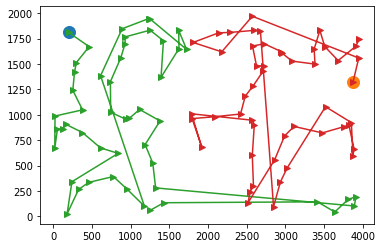

In [9]:
cycle=start_cycle_heuristic()
print(cycle)

cycle[0]: 14239.61072985149
cycle[1]: 15208.627404439962
[[93 81]
 [93 94]
 [93 12]
 ...
 [37 36]
 [37 32]
 [37 75]]
Initial distance: 29448.238134291452


TypeError: plotPartResult() missing 1 required positional argument: 'i'

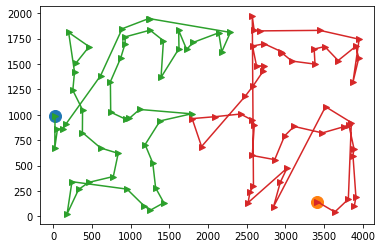

In [20]:
steep_search(dista,np_kroa)


In [173]:
cycle=change_vertices(cycle,81,44,False)

{0: array([81, 16, 14, 83, 98, 35, 37, 23, 17, 78, 93, 69, 21, 15, 87, 52, 18,
       74, 65, 25, 64,  3, 96, 55, 79, 30, 88, 41,  7, 91, 92,  0, 62,  5,
       48, 89,  9, 71, 20, 58, 73, 10, 46, 31, 90, 97, 61, 76, 59, 22]), 1: array([44, 94, 12, 51, 29,  1, 43, 49, 53, 39, 63, 34, 85, 26, 42, 40, 47,
       99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8, 86, 50, 66,
       27, 57, 60, 24, 80, 68, 72, 67, 84, 38, 95, 77,  4, 36, 32, 75])}


In [159]:
print(cycle)

{0: array([32, 75, 36, 51, 29,  1, 43, 49, 53, 39, 63, 34, 76, 59, 61, 85, 26,
       42, 40, 47, 99, 70, 13,  2, 45, 28, 33, 82, 54, 11, 19, 56,  6,  8,
       86, 50, 66, 27, 57, 60, 24, 80, 68, 72, 67, 84, 38, 95, 77,  4]), 1: array([98, 35, 37, 23, 17, 78, 83, 58, 16, 14, 22, 97, 44, 90, 46, 31, 10,
       73, 20, 71,  9, 89, 48,  5, 62, 12, 94, 81, 92,  0, 91,  7, 41, 88,
       30, 79, 55, 65, 25, 64,  3, 96, 74, 18, 52, 87, 15, 69, 21, 93])}
